# Image Analysis with Multiple AI Models

This notebook demonstrates and compares the capabilities of three different models for image analysis:

1. **Roboflow**: Fine-tuned instance segmentation model for detecting objects in images
2. **Azure GPT-4.1**: Multimodal model that can analyze images and respond to text prompts
3. **Swisscom Llama 3.2 Vision**: Another multimodal model capable of analyzing images and text prompts

We will use the same image and similar prompts across all models to compare their responses and capabilities.

Found .env file


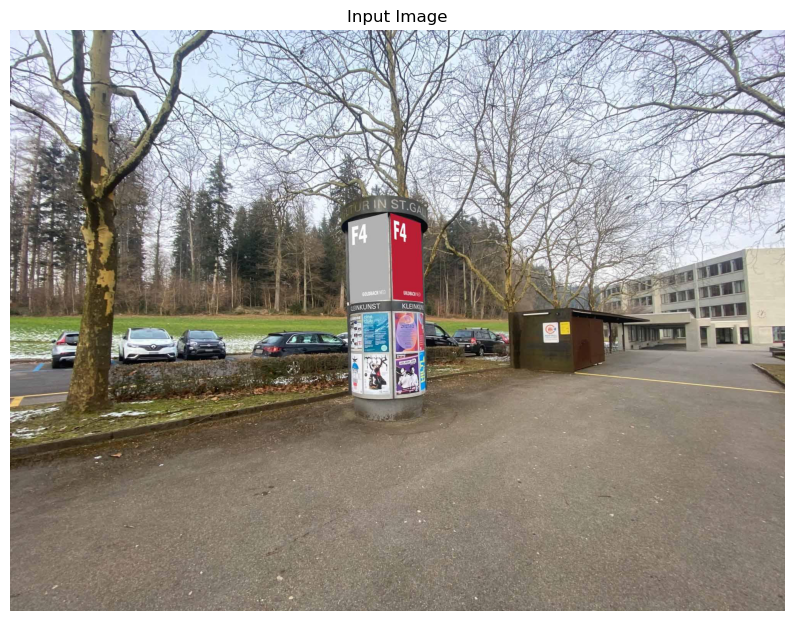

Image loaded successfully from Stellenbilder-no-augs/test/66229_jpg.rf.d4ba322d0570bb4e119115e226dcb558.jpg


In [10]:
# Load environment variables from .env file
import os
import base64
import json
from dotenv import load_dotenv
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import requests
import numpy as np

# Load environment variables
load_dotenv()

# Check if .env file exists, if not create a placeholder
try:
    with open('.env', 'r') as f:
        env_content = f.read()
    print("Found .env file")
except FileNotFoundError:
    env_content = """
ROBOFLOW_API_KEY=
SWISSCOM_AI_KEY=
SWISSCOM_AI_BASEURL=
SWISSCOM_AI_VISION_MODEL=meta/llama-3.2-90b-vision-instruct
AZURE_URL=
AZURE_API_KEY=
"""
    with open('.env', 'w') as f:
        f.write(env_content.strip())
    print("Created template .env file. Please fill in your API keys!")
    load_dotenv()  # Load again after creating the file

# Define the prompt to use for both text-based models
prompt = "Analyze this image and find RED and GREY marketing poster placeholders. Describe their content, placement, and potential audience."

# Define image path
img_path = "Stellenbilder-no-augs/test/66229_jpg.rf.d4ba322d0570bb4e119115e226dcb558.jpg"

# Create output directory for results if it doesn't exist
os.makedirs("output", exist_ok=True)

# Helper function to display images
def display_image(image_path):
    img = Image.open(image_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(np.array(img))
    plt.axis('off')
    plt.title("Input Image")
    plt.show()
    return img

# Display the input image
try:
    img = display_image(img_path)
    print(f"Image loaded successfully from {img_path}")
except Exception as e:
    print(f"Error loading image: {e}")
    # Try looking in the augmented folder instead
    img_path = "Stellenbilder-no-augs/test/66229_jpg.rf.d4ba322d0570bb4e119115e226dcb558.jpg"
    try:
        img = display_image(img_path)
        print(f"Image loaded successfully from {img_path}")
    except Exception as e:
        print(f"Still could not load image: {e}")
        print("Please ensure the image exists or update the path.")

## 1. Roboflow Model: Instance Segmentation

Using the fine-tuned Roboflow model to detect and segment objects in the image.

loading Roboflow workspace...
loading Roboflow project...
loading Roboflow project...
Using Roboflow model: Stellenbilder version 3
Running inference with Roboflow SDK...
Using Roboflow model: Stellenbilder version 3
Running inference with Roboflow SDK...


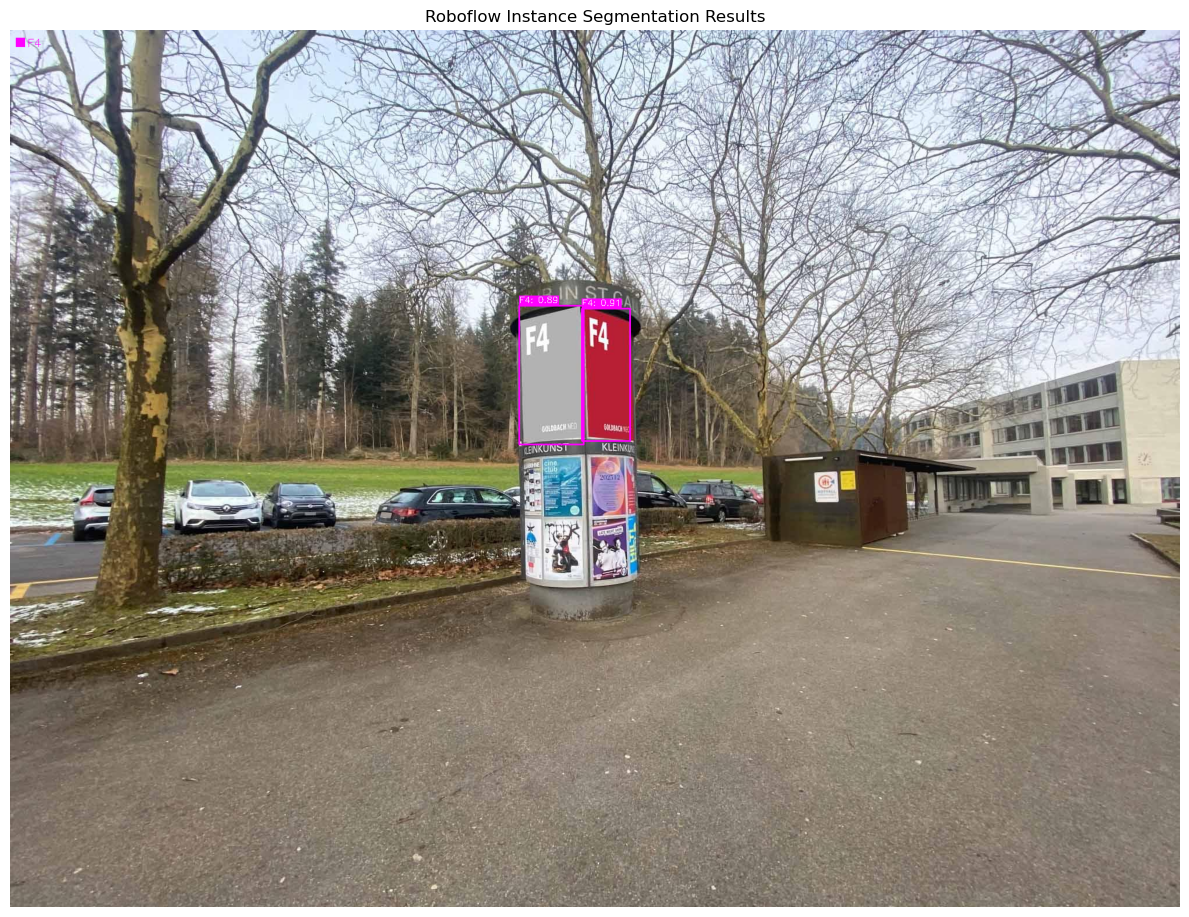

Saved visualization to output/roboflow_prediction.jpg
Classes detected: F4
Found 2 objects in the image.


In [11]:
# Get Roboflow API key
roboflow_api_key = os.getenv("ROBOFLOW_API_KEY")

if not roboflow_api_key:
    print("Roboflow API key not found in .env file. Skipping Roboflow model.")
else:
    try:
        from roboflow import Roboflow
        
        # Initialize Roboflow
        rf = Roboflow(api_key=roboflow_api_key)
        
        # Access Roboflow workspace and project
        project = rf.workspace("goldbach-neo-testspace").project("stellenbilder")
        
        # Get the model version
        model = project.version(3).model  # Using version 3 directly
        print(f"Using Roboflow model: {project.name} version 3")
        
        # Make prediction on the image
        print("Running inference with Roboflow SDK...")
        result = model.predict(img_path, confidence=0.4).json()
        
        # Save the raw result
        with open("output/roboflow_result.json", "w") as f:
            json.dump(result, f, indent=2)
        
        # For visualization function
        predictions = result  # This is already in the right format
        
        # Visualize the predictions
        def visualize_predictions(image_path, predictions):
            # Load image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Drawing parameters
            thickness = 2
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            font_thickness = 1
            colors = {
                "DIG": (255, 0, 0),        # Red
                "F12": (0, 255, 0),       # Green
                "F200": (0, 0, 255),      # Blue
                "F24": (255, 255, 0),     # Yellow
                "F4": (255, 0, 255),      # Magenta
                "Megaposter": (0, 255, 255),  # Cyan
                "default": (128, 128, 128) # Gray for any other class
            }
            
            # Keep track of all classes
            classes_found = set()
            
            # Draw predictions
            for pred in predictions['predictions']:
                # Get class name or default to 'unknown'
                class_name = pred.get('class', 'unknown')
                classes_found.add(class_name)
                confidence = pred.get('confidence', 0)
                
                # Get bounding box
                x = pred.get('x', 0)
                y = pred.get('y', 0)
                width = pred.get('width', 0)
                height = pred.get('height', 0)
                
                # Calculate box coordinates
                x1 = int(x - width/2)
                y1 = int(y - height/2)
                x2 = int(x + width/2)
                y2 = int(y + height/2)
                
                # Get color for class
                color = colors.get(class_name, colors['default'])
                
                # Draw bounding box
                cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
                
                # Add label with confidence
                label = f"{class_name}: {confidence:.2f}"
                (label_width, label_height), _ = cv2.getTextSize(label, font, font_scale, font_thickness)
                cv2.rectangle(image, (x1, y1 - label_height - 5), (x1 + label_width, y1), color, -1)
                cv2.putText(image, label, (x1, y1 - 5), font, font_scale, (255, 255, 255), font_thickness)
                
                # Draw mask if available
                if 'points' in pred and isinstance(pred['points'], dict):
                    points = pred['points']
                    for k, point_list in points.items():
                        # Convert points to NumPy array for drawing
                        pts = np.array(point_list, np.int32)
                        pts = pts.reshape((-1, 1, 2))
                        # Draw the polygon
                        cv2.polylines(image, [pts], True, color, 2)
            
            # Create a legend
            legend_y = 30
            for class_name in sorted(classes_found):
                color = colors.get(class_name, colors['default'])
                cv2.rectangle(image, (10, legend_y-15), (25, legend_y), color, -1)
                cv2.putText(image, class_name, (30, legend_y), font, font_scale*1.2, color, font_thickness)
                legend_y += 25
                
            # Display image
            plt.figure(figsize=(12, 10))
            plt.imshow(image)
            plt.axis('off')
            plt.title("Roboflow Instance Segmentation Results")
            plt.tight_layout()
            plt.show()
            
            # Save the visualization
            output_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            cv2.imwrite("output/roboflow_prediction.jpg", output_img)
            print("Saved visualization to output/roboflow_prediction.jpg")
            
            return classes_found
        
        # Visualize and get class information
        classes = visualize_predictions(img_path, predictions)
        print(f"Classes detected: {', '.join(classes)}")
        print(f"Found {len(predictions['predictions'])} objects in the image.")
        
    except Exception as e:
        print(f"Error with Roboflow model: {e}")
        import traceback
        traceback.print_exc()

## 2. Azure GPT-4.1: Multimodal Analysis

In [12]:
# Get Azure credentials
azure_api_key = os.getenv("AZURE_API_KEY")
azure_url = os.getenv("AZURE_URL") or "https://aihubgptrag0925019255.openai.azure.com/"

# Azure configuration
endpoint = azure_url
model_name = "gpt-4.1"
deployment = "gpt-4.1-workshop"
api_version = "2024-12-01-preview"

if not azure_api_key:
    print("Azure API key not found in .env file. Skipping Azure GPT-4.1 model.")
else:
    try:
        from openai import AzureOpenAI
        
        # Function to encode image to base64
        def encode_image(image_path):
            with open(image_path, "rb") as image_file:
                return base64.b64encode(image_file.read()).decode('utf-8')
        
        # Initialize Azure OpenAI client with the updated parameters
        client = AzureOpenAI(
            api_version=api_version,
            azure_endpoint=endpoint,
            api_key=azure_api_key,
        )
        
        # Encode the image
        base64_image = encode_image(img_path)
        
        # Prepare the message with image and text
        messages = [
            {
                "role": "system",
                "content": "You are a helpful assistant that analyzes images in detail."
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                ]
            }
        ]
        
        print("Sending request to Azure GPT-4.1...")
        
        # Call the model using the updated parameters
        response = client.chat.completions.create(
            messages=messages,
            max_completion_tokens=800,  # Changed from max_tokens
            temperature=0.7,
            top_p=1.0,
            frequency_penalty=0.0,
            presence_penalty=0.0,
            model=deployment  # Using the deployment name instead of model
        )
        
        # Print the response
        print("\n===== Azure GPT-4.1 Response =====\n")
        print(response.choices[0].message.content)
        print("\n==================================\n")
        
        # Save the response to a file
        with open("output/azure_gpt4_response.txt", "w") as f:
            f.write(response.choices[0].message.content)
        print("Saved Azure GPT-4.1 response to output/azure_gpt4_response.txt")
        
    except Exception as e:
        print(f"Error with Azure GPT-4.1 model: {e}")
        print("Try checking if the deployment name 'gpt-4.1-workshop' is correct for your Azure account.")

Sending request to Azure GPT-4.1...

===== Azure GPT-4.1 Response =====

Certainly! Here’s a detailed analysis of the RED and GREY marketing poster placeholders in the image:

### Placement
- The placeholders are located on a cylindrical advertising column situated near a parking lot and adjacent to what appears to be an educational or institutional building.
- The column is positioned at a walkway intersection, ensuring high visibility for pedestrians and drivers entering or leaving the parking area.

### Content

#### RED Placeholder
- **Color:** Bright red, immediately eye-catching and associated with urgent or important information.
- **Text:** 
  - “F4” (large, bold white letters at the top)
  - “KLEINPLAKAT” (smaller white text below)
- **Design:** Minimalist, solid color background with white lettering.
- **Purpose:** Likely a placeholder for a prominent advertisement or announcement, possibly for an event, sale, or urgent message.

#### GREY Placeholder
- **Color:** Medium grey

## 3. Swisscom Llama 3.2 Vision: Multimodal Analysis

Using Swisscom's Llama 3.2 vision model to analyze the image with a text prompt.

In [13]:
# Get Swisscom credentials
swisscom_api_key = os.getenv("SWISSCOM_AI_KEY")
swisscom_base_url = os.getenv("SWISSCOM_AI_BASEURL")
swisscom_vision_model = os.getenv("SWISSCOM_AI_VISION_MODEL", "meta/llama-3.2-90b-vision-instruct")

if not swisscom_api_key or not swisscom_base_url:
    print("Swisscom API key or base URL not found in .env file. Skipping Swisscom Llama 3.2 model.")
else:
    try:
        # Function to convert image to base64
        def image_to_base64(image_path):
            with open(image_path, "rb") as image_file:
                return base64.b64encode(image_file.read()).decode('utf-8')
        
        # Convert our image to base64
        image_base64 = image_to_base64(img_path)
        
        # Prepare the request to Swisscom API
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {swisscom_api_key}"
        }
        
        # Using the message format similar to vision_transformation.py
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}}
                ]
            }
        ]
        
        # Prepare payload
        payload = {
            "model": swisscom_vision_model,
            "messages": messages,
            "temperature": 0.5,
            "max_tokens": 800,
            "stream": False
        }
        
        print(f"Sending request to Swisscom Llama 3.2 Vision ({swisscom_vision_model})...")
        
        # Call the Swisscom API
        response = requests.post(
            f"{swisscom_base_url}/chat/completions",
            headers=headers,
            json=payload
        )
        
        # Check if the request was successful
        if response.status_code == 200:
            response_data = response.json()
            llama_response = response_data['choices'][0]['message']['content']
            
            # Print the response
            print("\n===== Swisscom Llama 3.2 Response =====\n")
            print(llama_response)
            print("\n==================================\n")
            
            # Save the response to a file
            with open("output/swisscom_llama_response.txt", "w") as f:
                f.write(llama_response)
            print("Saved Swisscom Llama 3.2 response to output/swisscom_llama_response.txt")
            
            # Print token usage if available
            if 'usage' in response_data:
                usage = response_data['usage']
                print(f"Token usage: {usage.get('total_tokens', 'N/A')} total tokens ")
                print(f"({usage.get('prompt_tokens', 'N/A')} prompt, {usage.get('completion_tokens', 'N/A')} completion)")
        else:
            print(f"Error: Received status code {response.status_code} from Swisscom API")
            print(f"Response: {response.text}")
            
    except Exception as e:
        print(f"Error with Swisscom Llama 3.2 model: {e}")

Sending request to Swisscom Llama 3.2 Vision (meta/llama-3.2-90b-vision-instruct)...

===== Swisscom Llama 3.2 Response =====

The image depicts a parking lot with a sign in the center, featuring two rectangular placeholders for marketing posters. The top placeholder is red and labeled "F4," while the bottom one is grey and also labeled "F4." These placeholders are likely intended to display information or advertisements related to the surrounding area.

Given their location in a parking lot, it can be inferred that the target audience for these marketing posters is likely individuals who frequent this area, such as students, faculty, or visitors. The content of the posters may include information about local events, services, or attractions, as well as advertisements for businesses or organizations in the vicinity.

Overall, the presence of these marketing poster placeholders suggests that the parking lot is a hub of activity and a prime location for reaching a diverse audience.


Sav

## Model Comparison and Analysis

This section can be used to compare the outputs of the three models and analyze their strengths and weaknesses.

1. **Roboflow** provides precise localization and classification of objects through instance segmentation.
2. **Azure GPT-4.1** offers detailed text analysis and understanding of the image content.
3. **Swisscom Llama 3.2** provides another perspective on image analysis with potentially different capabilities.

The differences in their outputs can help identify which model is best suited for specific use cases in your application.

In [14]:
# Load and display the model responses side by side (if available)
try:
    azure_response = ""
    llama_response = ""
    
    # Try to load Azure response
    try:
        with open("output/azure_gpt4_response.txt", "r") as f:
            azure_response = f.read()
    except FileNotFoundError:
        azure_response = "Azure GPT-4.1 response not available"
    
    # Try to load Swisscom response
    try:
        with open("output/swisscom_llama_response.txt", "r") as f:
            llama_response = f.read()
    except FileNotFoundError:
        llama_response = "Swisscom Llama 3.2 response not available"
    
    # Create a side-by-side comparison in markdown
    from IPython.display import Markdown, display
    
    comparison_md = """
    # Response Comparison
    
    | Azure GPT-4.1 | Swisscom Llama 3.2 |
    |---------------|--------------------|
    | {} | {} |
    """.format(azure_response.replace('\n', '<br>'), llama_response.replace('\n', '<br>'))
    
    display(Markdown(comparison_md))
    
    # Save comparison to a file
    with open("output/model_comparison.md", "w") as f:
        f.write(comparison_md)
    print("Saved comparison to output/model_comparison.md")
    
except Exception as e:
    print(f"Error creating comparison: {e}")


    # Response Comparison

    | Azure GPT-4.1 | Swisscom Llama 3.2 |
    |---------------|--------------------|
    | Certainly! Here’s a detailed analysis of the RED and GREY marketing poster placeholders in the image:<br><br>### Placement<br>- The placeholders are located on a cylindrical advertising column situated near a parking lot and adjacent to what appears to be an educational or institutional building.<br>- The column is positioned at a walkway intersection, ensuring high visibility for pedestrians and drivers entering or leaving the parking area.<br><br>### Content<br><br>#### RED Placeholder<br>- **Color:** Bright red, immediately eye-catching and associated with urgent or important information.<br>- **Text:** <br>  - “F4” (large, bold white letters at the top)<br>  - “KLEINPLAKAT” (smaller white text below)<br>- **Design:** Minimalist, solid color background with white lettering.<br>- **Purpose:** Likely a placeholder for a prominent advertisement or announcement, possibly for an event, sale, or urgent message.<br><br>#### GREY Placeholder<br>- **Color:** Medium grey, neutral and professional.<br>- **Text:**<br>  - “F4” (large, bold white letters at the top)<br>  - “GROSSPLAKAT” (smaller white text below)<br>- **Design:** Also minimalist, with a solid color and clear, bold typeface.<br>- **Purpose:** Placeholder for a large-scale advertisement, possibly for official notices, corporate marketing, or community information.<br><br>### Potential Audience<br>Given the location (near a parking area and what seems likely to be a school or university building), the intended audience includes:<br>- **Students and Faculty:** The nearby building and campus-like setting suggest a significant flow of students, teachers, and staff.<br>- **Visitors and Parents:** Those dropping off or picking up individuals, or attending events at the institution.<br>- **Commuters:** People parking their cars and walking into the building or campus.<br>- **General Public:** Anyone using the open space, such as joggers, walkers, or people using nearby amenities.<br><br>### Marketing Implications<br>- **RED Placeholder:** Suited for urgent announcements, events, or promotions that need to quickly grab attention.<br>- **GREY Placeholder:** Ideal for formal information, institutional announcements, or campaigns that require a neutral, trustworthy presentation.<br><br>### Summary Table<br><br>| Placeholder | Color | Text           | Placement         | Likely Content           | Target Audience                        |<br>|-------------|-------|----------------|-------------------|--------------------------|----------------------------------------|<br>| Red         | Red   | F4 KLEINPLAKAT | Top right column  | Event, urgent promotion  | Students, visitors, commuters          |<br>| Grey        | Grey  | F4 GROSSPLAKAT | Top left column   | Official info, large ad  | Students, faculty, general public      |<br><br>**In summary:** Both placeholders are designed for maximum visibility in a high-traffic area, with the red one aiming for attention-grabbing campaigns and the grey one lending itself to formal or large-scale marketing efforts targeting the campus and passerby populations. | The image depicts a parking lot with a sign in the center, featuring two rectangular placeholders for marketing posters. The top placeholder is red and labeled "F4," while the bottom one is grey and also labeled "F4." These placeholders are likely intended to display information or advertisements related to the surrounding area.<br><br>Given their location in a parking lot, it can be inferred that the target audience for these marketing posters is likely individuals who frequent this area, such as students, faculty, or visitors. The content of the posters may include information about local events, services, or attractions, as well as advertisements for businesses or organizations in the vicinity.<br><br>Overall, the presence of these marketing poster placeholders suggests that the parking lot is a hub of activity and a prime location for reaching a diverse audience. |
    

Saved comparison to output/model_comparison.md
